# 實驗：實作InceptionV3網路架構

### Import必要套件

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

---
## Keras Applications
### 創建InceptionV3網路架構
- 輸入大小(預設)：(299, 299, 3)
- 權重(預設)：`imagenet`
- 輸出類別(預設)：1000個類別

In [2]:
model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

透過`model.summary`可以察看網路模型的每一層資訊：

In [3]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

將網路模型儲存到TensorBoard上：

In [4]:
model_tb = tf.keras.callbacks.TensorBoard(log_dir='lab8-logs-inceptionv3-keras')
model_tb.set_model(model)

rm: cannot remove 'lab8-inceptionv3-keras': No such file or directory


### 資料前處理和輸出解碼

使用別人提供的模型預測，需要注意兩件事情，1)訓練時的資料前處理，2)輸出結果對應到的類別。

Keras很貼心的提供每個模型相對應的資料預處理和輸出解碼的函式。
- preprocess_input：網路架構的影像前處理(注意：每一個模型在訓練時做的資料正規化並不會相同，例如：VGG、ResNet-50輸入影像為0~255的數值，而inception_v3、xception輸入影像為-1~1的數值)。
- decode_predictions：對應網路架構的輸出解碼。

Import資料預處理和輸出解碼的函式：

In [5]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions

### 預測輸出結果

創建影像讀取的函式：讀取影像，並將影像大小縮放大299x299x3的尺寸。

In [6]:
def read_img(img_path, resize=(299,299)):
    img_string = tf.io.read_file(img_path)  # 讀取檔案
    img_decode = tf.image.decode_image(img_string)  # 將檔案以影像格式來解碼
    img_decode = tf.image.resize(img_decode, resize)  # 將影像resize到網路輸入大小
    # 將影像格式增加到4維(batch, height, width, channels)，模型預測要求格式
    img_decode = tf.expand_dims(img_decode, axis=0)
    return img_decode

從資料夾中讀取一張影像（elephant.jpg）作為測試：

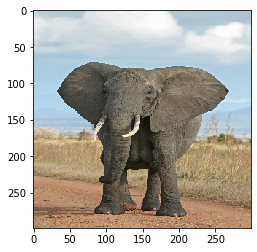

In [7]:
img_path = 'image/elephant.jpg'
img = read_img(img_path)  # 透過剛創建的函式讀取影像
plt.imshow(tf.cast(img, tf.uint8)[0])  # 透過matplotlib顯示圖片需將影像轉為Integers

預測結果：

In [8]:
img = preprocess_input(img)  # 影像前處理
preds = model.predict(img)  # 預測圖片
print("Predicted:", decode_predictions(preds, top=3)[0])  # 輸出預測最高的三個類別

Predicted: [('n02504458', 'African_elephant', 0.8037859), ('n01871265', 'tusker', 0.12163948), ('n02504013', 'Indian_elephant', 0.004299275)]


---
## TensorFlow Hub

Install:
```
pip install tensorflow-hub
```

Search:
https://tfhub.dev/

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

### 創建Inception V3模型

Model:
https://tfhub.dev/google/tf2-preview/inception_v3/classification/2

num_classes = 1001 classes of the classification from the original training
 
Image:height x width = 299 x 299 pixels, 3 RGB color values in the range 0~1

labels file: https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [12]:
# Inception V3預訓練模型的URL
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

# 創建一個Sequential Model，網路模型裡面包含了Inception V3網路層
model = tf.keras.Sequential([
    # hub.KerasLayer將載入的Inception V3模型封裝成網路層(Keras Layer)
    hub.KerasLayer(module_url, 
                  input_shape=(299, 299, 3),  # 模型輸入大小
                   output_shape=(1001, ),   # 模型輸出大小
                   name='Inception_v3')  # 網路層名稱
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inception_v3 (KerasLayer)    (None, 1001)              23853833  
Total params: 23,853,833
Trainable params: 0
Non-trainable params: 23,853,833
_________________________________________________________________


### 資料前處理和輸出解碼

創建資料前處理函式：

In [15]:
def read_img(img_path, resize=(299,299)):
    img_string = tf.io.read_file(img_path)  # 讀取檔案
    img_decode = tf.image.decode_image(img_string)  # 將檔案以影像格式來解碼
    img_decode = tf.image.resize(img_decode, resize)  # 將影像resize到網路輸入大小
    img_decode = img_decode / 255.0  # 對影像做正規畫，將數值縮放到0~1之間
    # 將影像格式增加到4維(batch, height, width, channels)，模型預測要求格式
    img_decode = tf.expand_dims(img_decode, axis=0)  # 
    return img_decode

創建輸出解碼器：

In [16]:
# 下載ImageNet 的標籤檔
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# 讀取標籤檔中的數據
with open(labels_path) as file:
    lines = file.read().splitlines()
print(lines)  # 顯示讀取的標籤

imagenet_labels = np.array(lines)  # 將標籤轉成numpy array做為網路輸出的解碼器

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', '

### 預測輸出結果

從資料夾中讀取一張影像（elephant.jpg）作為測試：

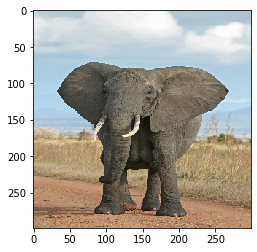

In [17]:
img_path = 'image/elephant.jpg'
img = read_img(img_path)  # 透過剛創建的函式讀取影像
plt.imshow(img[0])

預測結果：

In [18]:
preds = model.predict(img)  # 預測圖片
index = np.argmax(preds)  # 取得預測結果最大的Index
print("Predicted:", imagenet_labels[index])  # 透過解碼器將輸出轉成標籤

Predicted: African elephant


顯示最好的三個預測：

In [19]:
# 取得預測結果最大的三個indexs
top3_indexs = np.argsort(preds)[0, ::-1][:3]  
print("Predicted:", imagenet_labels[top3_indexs])  # 透過解碼器將輸出轉成標籤

Predicted: ['African elephant' 'tusker' 'Indian elephant']
